# Assignment 1
Chetan Goel

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

device(type='cpu')

In [2]:
# Initializations and imports
import numpy as np
import matplotlib.pyplot as plt
_seed = np.random.default_rng(0)

## Mixture of Gaussians Dataset
Develop a toy dataset of $m=1000$ sample points for Mixture of Gaussians (MoG):

- Feature dimensions: 2
- Number of Gaussian components: 3
- Means: random.
- Covariance matrices: diagonal.
- Create visualizations for dataset.

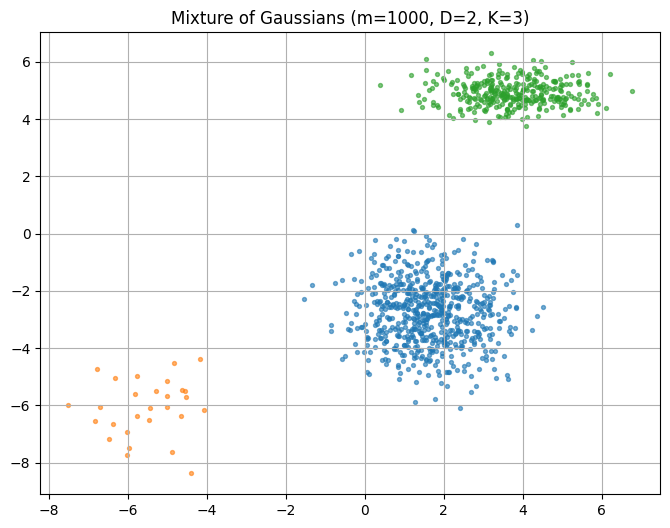

In [3]:
m = 1000
K = 3
D = 2

means = _seed.uniform(-6, 6, size=(K, D))
variances = _seed.uniform(0.2, 1.5, size=(K, D))
weights = _seed.dirichlet(np.ones(K), size=1).ravel()
components = _seed.choice(K, size=m, p=weights)

X = np.zeros((m, D))
for k in range(K):
    idx = components == k
    n_k = idx.sum()
    cov_k = np.diag(variances[k])
    if n_k > 0:
        X[idx] = _seed.multivariate_normal(means[k], cov_k, size=n_k)

plt.figure(figsize=(8, 6))
colors = ['C0', 'C1', 'C2']
for k in range(K):
    idx = components == k
    plt.scatter(X[idx, 0], X[idx, 1], s=8, color=colors[k], alpha=0.6, label=f'Comp {k+1}')

plt.title('Mixture of Gaussians (m=1000, D=2, K=3)')
plt.grid(True)
plt.show()


## SGD from Scratch for 3-Component, 3-Feature MoG
Implement Stochastic Gradient Descent (SGD) from scratch with the Negative Log-Likelihood (NLL) objective and analytic derivatives to optimize the parameters.

Notes:

- Initialize covariance matrices as diagonal.
For a mini-batch $B$, provide expressions for the gradients below.
- Re-parameterize variance as $log(\sigma)$ to keep the model stable and avoid invalid variances while applying SGD.
Provide and use the following in your write-up/code:

# Responsibility function

The responsibility function for component $k$ and data point $i$:

$$
\gamma_{ik} = \frac{\pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \, \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}.
$$

---

# Mean gradient

For a mini-batch $\mathcal{B}$:

$$
\frac{\partial \mathcal{L}_B}{\partial \mu_k} = \sum_{i \in \mathcal{B}} \gamma_{ik} \, \Sigma_k^{-1} (x_i - \mu_k).
$$

---

# Variance gradient

For diagonal covariance matrices:

$$
\frac{\partial \mathcal{L}_B}{\partial \log \sigma_{kd}^2} 
= \frac{1}{2} \sum_{i \in \mathcal{B}} \gamma_{ik} \left[ \frac{(x_{id} - \mu_{kd})^2}{\sigma_{kd}^2} - 1 \right],
$$

where $d$ indexes the feature dimension.

---

# Mixture weights gradient

For the mixture weights (with softmax re-parameterization):

$$
\frac{\partial \mathcal{L}_B}{\partial \pi_k} = \sum_{i \in \mathcal{B}} \frac{\gamma_{ik}}{\pi_k}.
$$


In [4]:
# SGD implementation for Mixture of Gaussians (MoG) with diagonal covariance and log-variance parameterization
def log_gaussian_pdf(X, mu, log_var):
    """
    Compute log PDF of diagonal Gaussian for each component.
    X: (N, D) data
    mu: (K, D) means
    log_var: (K, D) log-variances
    Returns: (N, K) log-probabilities
    """
    N, D = X.shape
    K = mu.shape[0]
    var = np.exp(log_var)
    out = np.zeros((N, K))
    for k in range(K):
        diff = X - mu[k]
        log_det = np.sum(np.log(var[k]))
        m_dist = np.sum((diff ** 2) / var[k], axis=1)
        out[:, k] = -0.5 * (D * np.log(2 * np.pi) + log_det + m_dist)
    return out

def sgd_mog(X, K, D, batch_size=64, lr=1e-2, n_iter=500):
    """
    Stochastic Gradient Descent for MoG with diagonal covariance.
    Returns learned means, variances, mixture weights, and loss history.
    """
    rng = np.random.RandomState(0)
    m = X.shape[0]
    mu = rng.uniform(-6, 6, size=(K, D))
    log_var = rng.uniform(np.log(0.2), np.log(1.5), size=(K, D))
    logits = rng.normal(0, 1, size=K)  # for softmax mixture weights

    loss_hist = []
    for _ in range(n_iter):
        idx = rng.choice(m, batch_size, replace=False)
        xb = X[idx]

        # Softmax for mixture weights
        pi = np.exp(logits - np.max(logits))
        pi /= pi.sum()

        # Compute log-probabilities for each component
        log_pdf = log_gaussian_pdf(xb, mu, log_var)
        log_prob = log_pdf + np.log(pi + 1e-10)

        # Responsibilities (gamma)
        mx = np.max(log_prob, axis=1, keepdims=True)
        p = np.exp(log_prob - mx)
        denom = p.sum(axis=1, keepdims=True)
        gamma = p / denom

        # Negative log-likelihood loss
        ll = np.sum(np.log(denom + 1e-10) + mx.ravel())
        loss_hist.append(-ll / batch_size)

        var = np.exp(log_var)
        mu_g = np.zeros_like(mu)
        lv_g = np.zeros_like(log_var)
        logit_g = np.zeros_like(logits)

        # Gradients for each parameter
        for k in range(K):
            gk = gamma[:, k][:, None]
            mu_g[k] = (gk * (xb - mu[k]) / var[k]).sum(axis=0)
            lv_g[k] = 0.5 * (gk * ((xb - mu[k]) ** 2 / var[k] - 1)).sum(axis=0)
            logit_g[k] = gamma[:, k].sum() - batch_size * pi[k]

        # SGD updates
        mu += lr * mu_g / batch_size
        log_var += lr * lv_g / batch_size
        logits += lr * logit_g / batch_size

    # Final mixture weights
    pi = np.exp(logits - np.max(logits))
    pi /= pi.sum()
    return mu, np.exp(log_var), pi, loss_hist


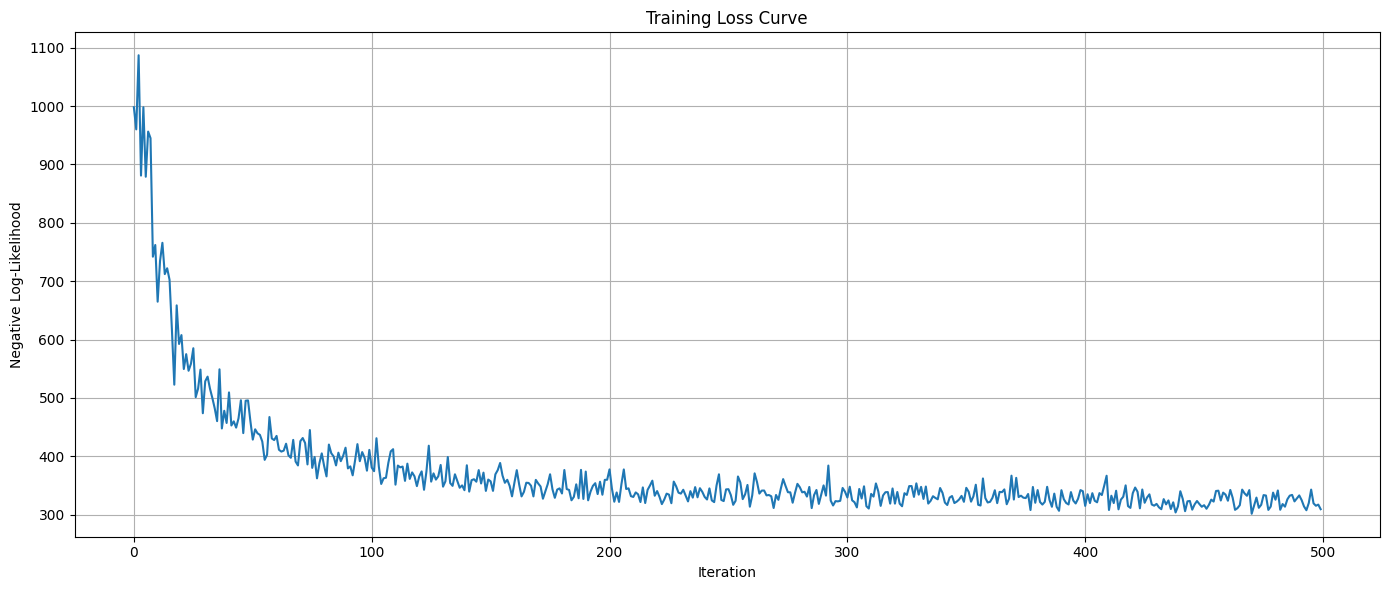

True mixture weights: [0.66523001 0.02125413 0.31351586]
Learned mixture weights: [0.84352865 0.07763645 0.0788349 ]
True means:
 [[ 1.64354025 -2.76255943]
 [-5.50831771 -5.80166837]
 [ 3.75924287  4.95306693]]
Learned means:
 [[ 1.93991029  1.47169465]
 [ 1.2675931   0.04507069]
 [-0.91551958  1.74633103]]


In [5]:
mu_learned, var_learned, pi_learned, loss_history = sgd_mog(X, K, D, batch_size=64, lr=1e-2, n_iter=500)
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# Loss history plot
axes.plot(loss_history)
axes.set_xlabel('Iteration')
axes.set_ylabel('Negative Log-Likelihood')
axes.set_title('Training Loss Curve')
axes.grid(True)

plt.tight_layout()
plt.show()

print("True mixture weights:", weights)
print("Learned mixture weights:", pi_learned)
print("True means:\n", means)
print("Learned means:\n", mu_learned)